In [36]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32922 sha256=787ce3ec1abcd685b6ee4bb41c3fa679e00b682439b63b69b7ae34285f5cb3d8
  Stored in directory: C:\Users\alex-\AppData\Local\pip\Cache\wheels\75\37\6a\2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [37]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import unidecode

from sklearn import preprocessing
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from stop_words import get_stop_words

In [3]:
## NOMBRE DE PAGE DE FILM A RECUPERER
NB_PAGE = 10

In [4]:
pages_url = []

films_df = pd.DataFrame(columns=['nom_film', 'ref'])#, 'global_note'])
note_tab = []

for page in range(1, NB_PAGE):
    page = requests.get("http://www.allocine.fr/films/?page="+str(page))
    soup = BeautifulSoup(page.content, 'html.parser')
    bs4_res = soup.find_all('a', class_='meta-title-link')

    for film in bs4_res:
        films_df = films_df.append( {"ref": film.attrs['href'], "nom_film": film.contents[0]}, ignore_index=True)


In [5]:
films_df.head(9)

nom_film  \
0                                              1917   
1                                 La Fille du train   
2                                       Jojo Rabbit   
3                                          Scandale   
4  Je voudrais que quelqu'un m'attende quelque part   
5                                 Bad Boys For Life   
6                                            Selfie   
7                       Les Filles du Docteur March   
8                                   Les Traducteurs   

                                     ref  
0  /film/fichefilm_gen_cfilm=265567.html  
1  /film/fichefilm_gen_cfilm=234725.html  
2  /film/fichefilm_gen_cfilm=258998.html  
3  /film/fichefilm_gen_cfilm=268490.html  
4  /film/fichefilm_gen_cfilm=147622.html  
5  /film/fichefilm_gen_cfilm=172048.html  
6  /film/fichefilm_gen_cfilm=265262.html  
7  /film/fichefilm_gen_cfilm=224808.html  
8  /film/fichefilm_gen_cfilm=261613.html

In [6]:
comment_url_tab = []
for index, row in films_df.iterrows():
    url = "http://www.allocine.fr/film/fichefilm-" + row['ref'].split("=")[1].split('.')[0] + "/critiques/spectateurs/"
    film_page = requests.get(url)
    soup = BeautifulSoup(film_page.content, 'html.parser')
    bs4_res = soup.find_all('span', class_='note')
    
    if len(bs4_res) == 0:
        films_df.drop(index, inplace=True)
        continue
        
    note = bs4_res[0].contents
    note_tab.append(note)
    comment_url_tab.append(url)
    
print(len(note_tab))
films_df = films_df.assign(note=np.array(note_tab))
films_df = films_df.assign(comment_url=np.array(comment_url_tab)).reset_index(drop=True)

26


In [7]:
films_df.head(9)

nom_film  \
0                                              1917   
1                                 La Fille du train   
2                                          Scandale   
3  Je voudrais que quelqu'un m'attende quelque part   
4                                 Bad Boys For Life   
5                                            Selfie   
6                       Les Filles du Docteur March   
7                                       San Andreas   
8                                    Le Photographe   

                                     ref note  \
0  /film/fichefilm_gen_cfilm=265567.html  4,4   
1  /film/fichefilm_gen_cfilm=234725.html  3,3   
2  /film/fichefilm_gen_cfilm=268490.html  3,6   
3  /film/fichefilm_gen_cfilm=147622.html  3,7   
4  /film/fichefilm_gen_cfilm=172048.html  4,0   
5  /film/fichefilm_gen_cfilm=265262.html  2,5   
6  /film/fichefilm_gen_cfilm=224808.html  4,0   
7  /film/fichefilm_gen_cfilm=200433.html  3,0   
8  /film/fichefilm_gen_cfilm=257183.html  3,4   

                                         comment_url  
0  http://www.allocine.fr/film/fichefilm-265567/c...  
1  http://www.allocine.fr/film/fichefilm-234725/c...  
2  http://www.allocine.fr/film/fichefilm-268490/c...  
3  http://www.allocine.fr/film/fichefilm-147622/c...  
4  http://www.allocine.fr/film/fichefilm-172048/c...  
5  http://www.allocine.fr/film/fichefilm-265262/c...  
6  http://www.allocine.fr/film/fichefilm-224808/c...  
7  http://www.allocine.fr/film/fichefilm-200433/c...  
8  http://www.allocine.fr/film/fichefilm-257183/c...

In [10]:
comment_df = pd.DataFrame(columns=['comment','note', 'film_ref'])
for index, row in films_df.iterrows():
    print(index)
    print(row['nom_film'])
    comment_page = 1
    film_page = requests.get(row['comment_url']+'?page='+str(comment_page))
    soup = BeautifulSoup(film_page.content, 'html.parser')
    bs4_page = soup.find_all('span', class_='current-item')
    if(len(bs4_page) == 0):
        continue
    actual_comment_page = bs4_page[0].contents[0]
    
    while(int(actual_comment_page) == int(comment_page)): 
        comment_page+=1
        film_page = requests.get(row['comment_url']+'?page='+str(comment_page))
        soup = BeautifulSoup(film_page.content, 'html.parser')
        bs4_page = soup.find_all('span', class_='current-item')
        if(len(bs4_page) == 0):
            continue
        actual_comment_page = bs4_page[0].contents[0]
        
        bs4_note = soup.find_all('span', class_='stareval-note')
        bs4_comments = soup.find_all('div', class_='content-txt')
      
        for (note, comment) in zip(bs4_note[:15], bs4_comments):
            comment_df = comment_df.append({"comment":comment.contents[0], 'note':float(note.contents[0].replace(',', '.')), 'film_ref': row['ref']}, ignore_index=True)

0
1917
1
La Fille du train
2
Scandale
3
Je voudrais que quelqu'un m'attende quelque part
4
Bad Boys For Life
5
Selfie
6
Les Filles du Docteur March
7
San Andreas
8
Le Photographe
9
Une belle équipe
10
Les Vétos
11
Les Incognitos
12
Les Enfants du temps
13
Les Misérables
14
Qu'un sang impur...
15
Star Wars: L'Ascension de Skywalker
16
À couteaux tirés
17
K contraire
18
Underwater
19
La Llorona
20
Marche avec les loups
21
Play
22
Parasite
23
L'Adieu (The Farewell)
24
Exodus
25
Séjour dans les monts Fuchun


In [12]:
comment_df

comment  note  \
0     \n                      Sans intérêt. Scénario...   2.0   
1     \n                      Trop grand spectacle. ...   1.0   
2     \n                      Allez soyons franc, « ...   3.5   
3     \n                      Bienvenue dans la gran...   1.0   
4     \n                      Pire que Dunkerque !\n...   1.0   
...                                                 ...   ...   
7454  \n                      Chef d’oeuvre d’une ra...   5.0   
7455  \n                      Superbe, poétique, j'a...   5.0   
7456  \n                      Quelle idée géniale de...   4.5   
7457  \n                      Je viens de voir un fi...   4.5   
7458  \n                      Lent ; plans séquences...   3.0   

                                   film_ref  
0     /film/fichefilm_gen_cfilm=265567.html  
1     /film/fichefilm_gen_cfilm=265567.html  
2     /film/fichefilm_gen_cfilm=265567.html  
3     /film/fichefilm_gen_cfilm=265567.html  
4     /film/fichefilm_gen_cfilm=265567.html  
...                                     ...  
7454  /film/fichefilm_gen_cfilm=273659.html  
7455  /film/fichefilm_gen_cfilm=273659.html  
7456  /film/fichefilm_gen_cfilm=273659.html  
7457  /film/fichefilm_gen_cfilm=273659.html  
7458  /film/fichefilm_gen_cfilm=273659.html  

[7459 rows x 3 columns]

In [27]:
#comment_df['comment_clean'] = comment_df['comment'].map(lambda x: x.lower())
comment_df['comment_clean'] = comment_df['comment'].map(lambda x: " ".join(x.split()))
comment_df['comment_clean'] = comment_df['comment_clean'].map(lambda x: x.strip())
comment_df['comment_clean'] = comment_df['comment_clean'].map(lambda x: unidecode.unidecode(x))

In [28]:
comment_df

comment  note  \
0     \n                      Sans intérêt. Scénario...   2.0   
1     \n                      Trop grand spectacle. ...   1.0   
2     \n                      Allez soyons franc, « ...   3.5   
3     \n                      Bienvenue dans la gran...   1.0   
4     \n                      Pire que Dunkerque !\n...   1.0   
...                                                 ...   ...   
7454  \n                      Chef d’oeuvre d’une ra...   5.0   
7455  \n                      Superbe, poétique, j'a...   5.0   
7456  \n                      Quelle idée géniale de...   4.5   
7457  \n                      Je viens de voir un fi...   4.5   
7458  \n                      Lent ; plans séquences...   3.0   

                                   film_ref  \
0     /film/fichefilm_gen_cfilm=265567.html   
1     /film/fichefilm_gen_cfilm=265567.html   
2     /film/fichefilm_gen_cfilm=265567.html   
3     /film/fichefilm_gen_cfilm=265567.html   
4     /film/fichefilm_gen_cfilm=265567.html   
...                                     ...   
7454  /film/fichefilm_gen_cfilm=273659.html   
7455  /film/fichefilm_gen_cfilm=273659.html   
7456  /film/fichefilm_gen_cfilm=273659.html   
7457  /film/fichefilm_gen_cfilm=273659.html   
7458  /film/fichefilm_gen_cfilm=273659.html   

                                          comment_clean  note_normalized label  
0     Sans interet. Scenario farfelu qui ressemble, ...         0.333333   neg  
1     Trop grand spectacle. On se croirait dans supe...         0.111111   neg  
2     Allez soyons franc, << 1917 >> est un film de ...         0.666667   pos  
3     Bienvenue dans la grande guerre en mode JEU VI...         0.111111   neg  
4     Pire que Dunkerque ! un gars doit remettre une...         0.111111   neg  
...                                                 ...              ...   ...  
7454  Chef d'oeuvre d'une rare beaute et d'une grand...         1.000000   pos  
7455  Superbe, poetique, j'avais l'impression d'etre...         1.000000   pos  
7456  Quelle idee geniale de filmer une famille chin...         0.888889   pos  
7457  Je viens de voir un film unique. Il est comple...         0.888889   pos  
7458  Lent ; plans sequences interminables ; montage...         0.555556   pos  

[7459 rows x 6 columns]

### NORMALISATION DES DONNEES 

In [29]:
THRESHOLD = 0.5
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(comment_df[['note']])
comment_df['note_normalized'] = x_scaled


### ANNOTATION DES DONNEES 

In [30]:
comment_df['label'] = np.where(comment_df['note_normalized'] >= THRESHOLD, "pos", "neg")

In [31]:
comment_df

comment  note  \
0     \n                      Sans intérêt. Scénario...   2.0   
1     \n                      Trop grand spectacle. ...   1.0   
2     \n                      Allez soyons franc, « ...   3.5   
3     \n                      Bienvenue dans la gran...   1.0   
4     \n                      Pire que Dunkerque !\n...   1.0   
...                                                 ...   ...   
7454  \n                      Chef d’oeuvre d’une ra...   5.0   
7455  \n                      Superbe, poétique, j'a...   5.0   
7456  \n                      Quelle idée géniale de...   4.5   
7457  \n                      Je viens de voir un fi...   4.5   
7458  \n                      Lent ; plans séquences...   3.0   

                                   film_ref  \
0     /film/fichefilm_gen_cfilm=265567.html   
1     /film/fichefilm_gen_cfilm=265567.html   
2     /film/fichefilm_gen_cfilm=265567.html   
3     /film/fichefilm_gen_cfilm=265567.html   
4     /film/fichefilm_gen_cfilm=265567.html   
...                                     ...   
7454  /film/fichefilm_gen_cfilm=273659.html   
7455  /film/fichefilm_gen_cfilm=273659.html   
7456  /film/fichefilm_gen_cfilm=273659.html   
7457  /film/fichefilm_gen_cfilm=273659.html   
7458  /film/fichefilm_gen_cfilm=273659.html   

                                          comment_clean  note_normalized label  
0     Sans interet. Scenario farfelu qui ressemble, ...         0.333333   neg  
1     Trop grand spectacle. On se croirait dans supe...         0.111111   neg  
2     Allez soyons franc, << 1917 >> est un film de ...         0.666667   pos  
3     Bienvenue dans la grande guerre en mode JEU VI...         0.111111   neg  
4     Pire que Dunkerque ! un gars doit remettre une...         0.111111   neg  
...                                                 ...              ...   ...  
7454  Chef d'oeuvre d'une rare beaute et d'une grand...         1.000000   pos  
7455  Superbe, poetique, j'avais l'impression d'etre...         1.000000   pos  
7456  Quelle idee geniale de filmer une famille chin...         0.888889   pos  
7457  Je viens de voir un film unique. Il est comple...         0.888889   pos  
7458  Lent ; plans sequences interminables ; montage...         0.555556   pos  

[7459 rows x 6 columns]

## GLOBAL WORD CLOUD

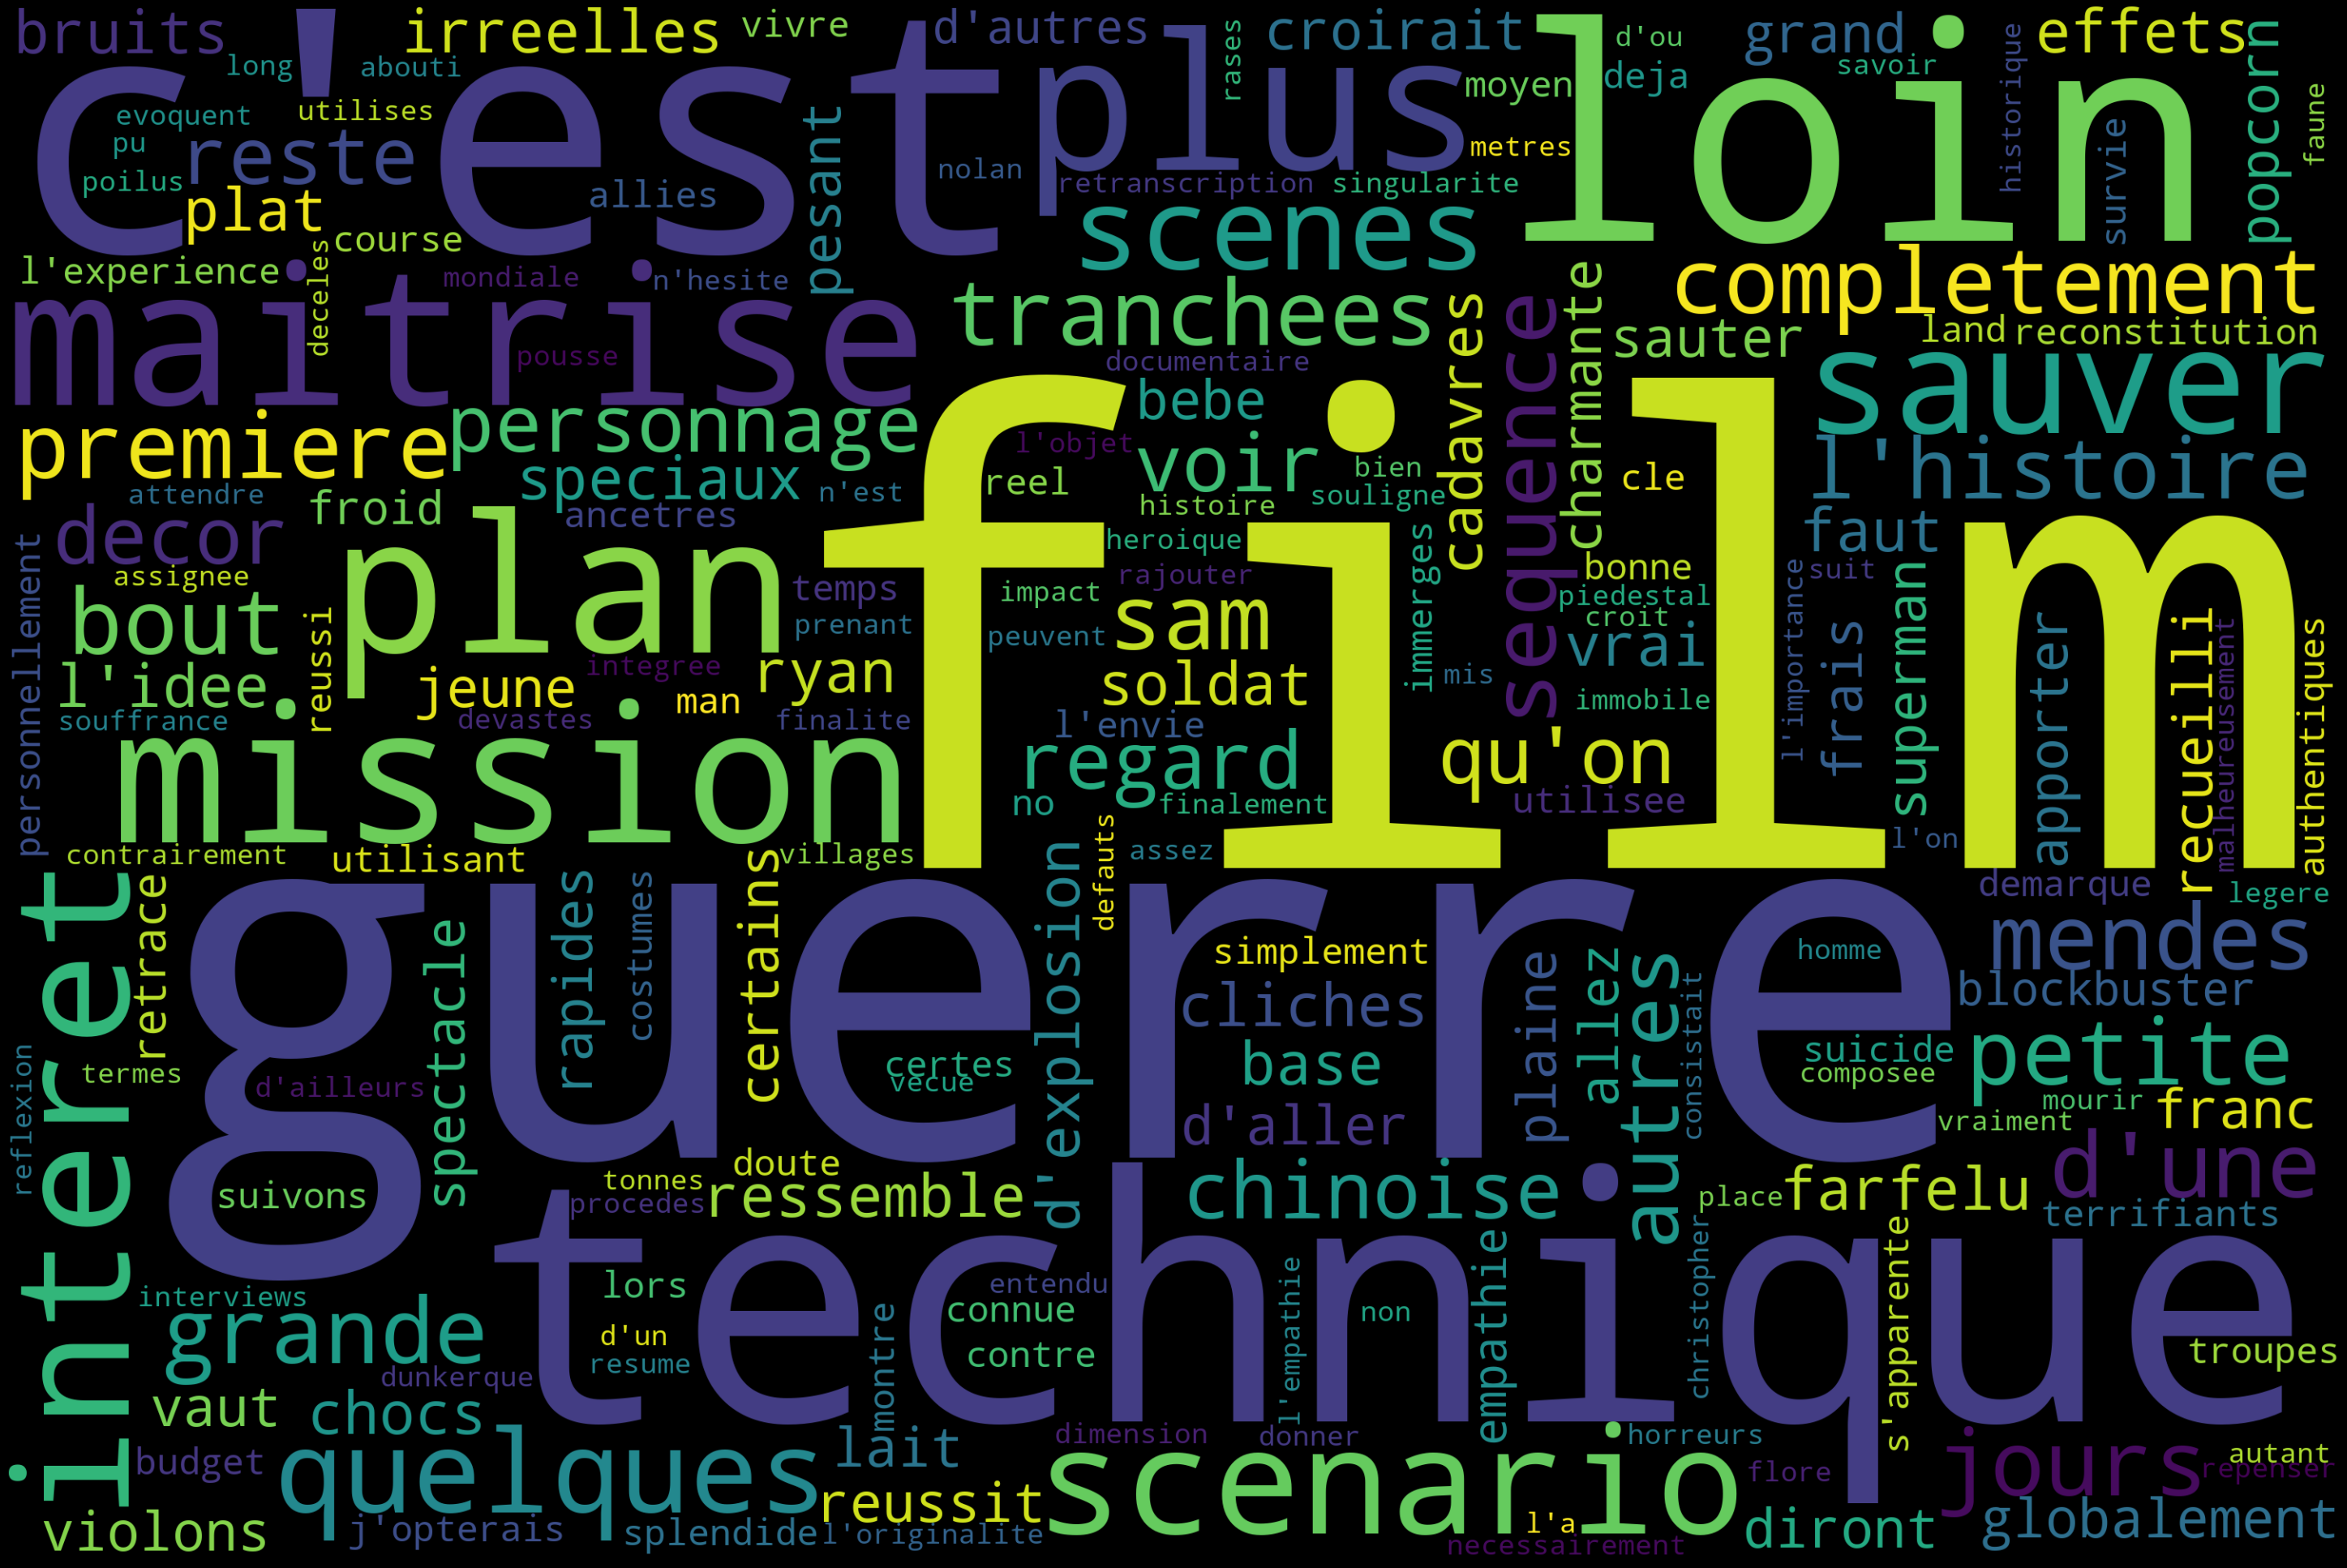

In [54]:
text = comment_df['comment_clean'].map(lambda x: x .lower()).values
french_stop_words = [unidecode.unidecode(word) for word in get_stop_words('fr')]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = french_stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## NEG WORD CLOUD

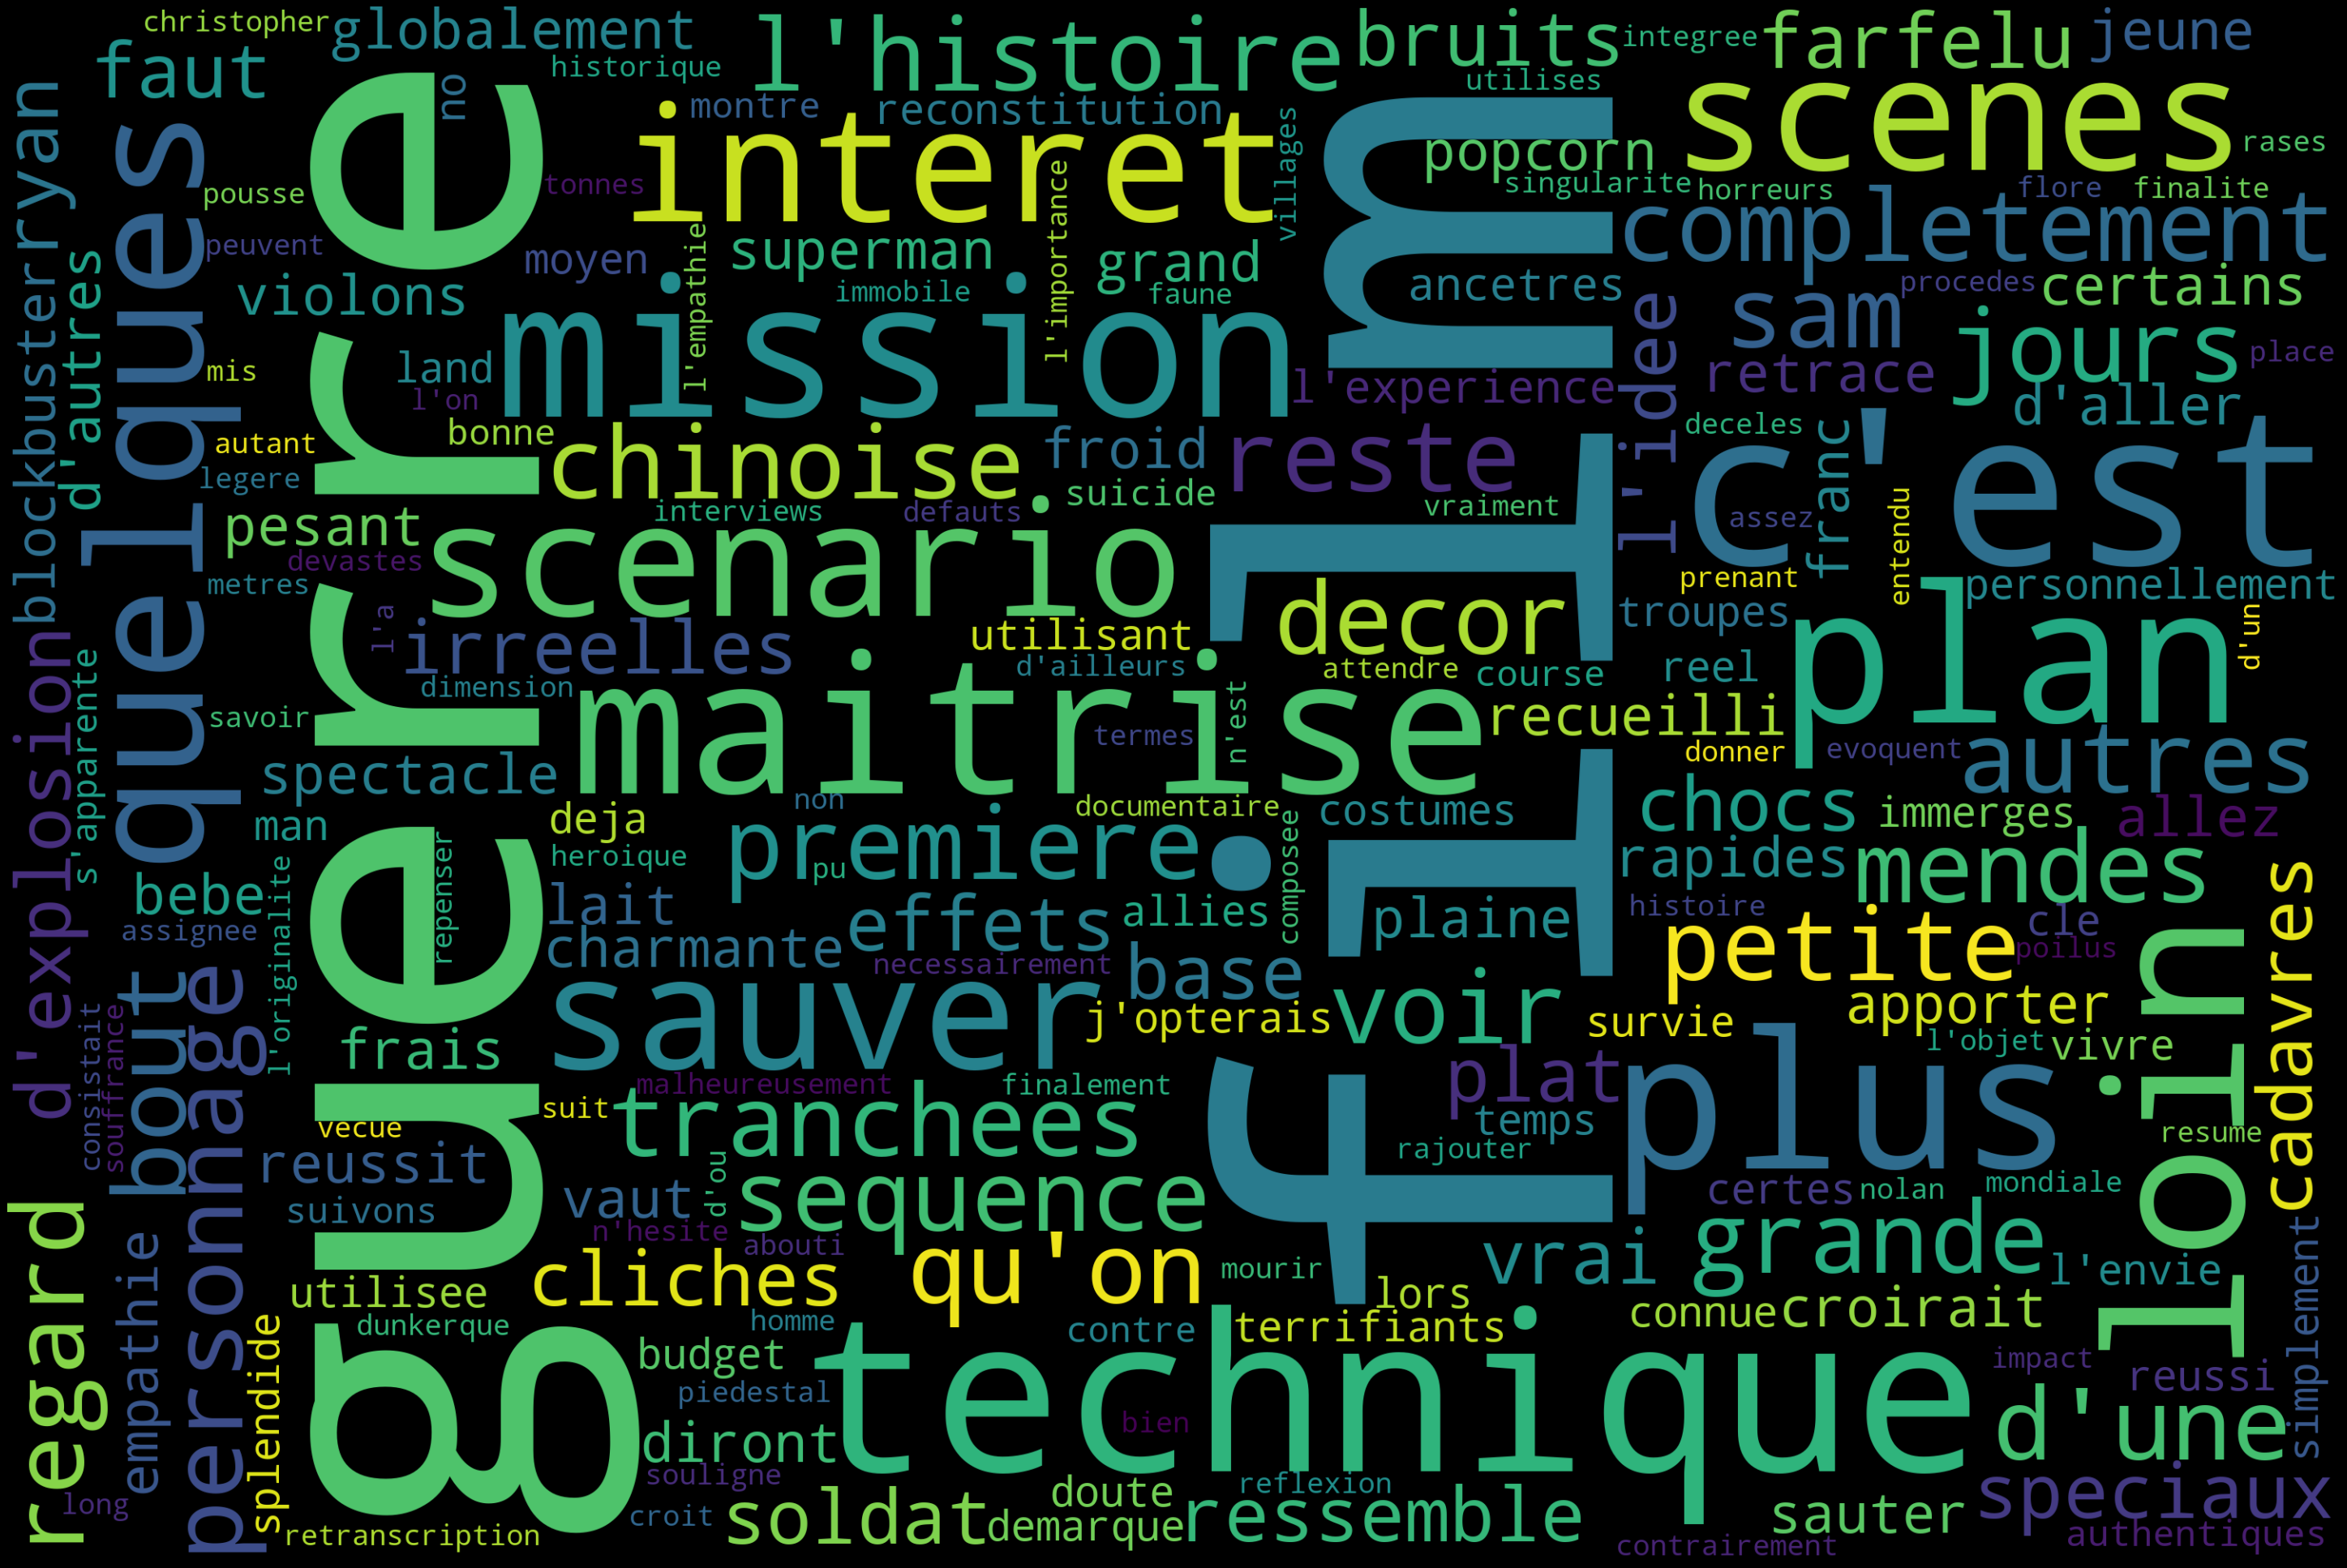

In [58]:
neg_df = comment_df.loc[comment_df['label'] == 'neg']
neg_text = [string.lower() for string in neg_df['label']]
french_stop_words = [unidecode.unidecode(word) for word in get_stop_words('fr')]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = french_stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## POS WORD CLOUD

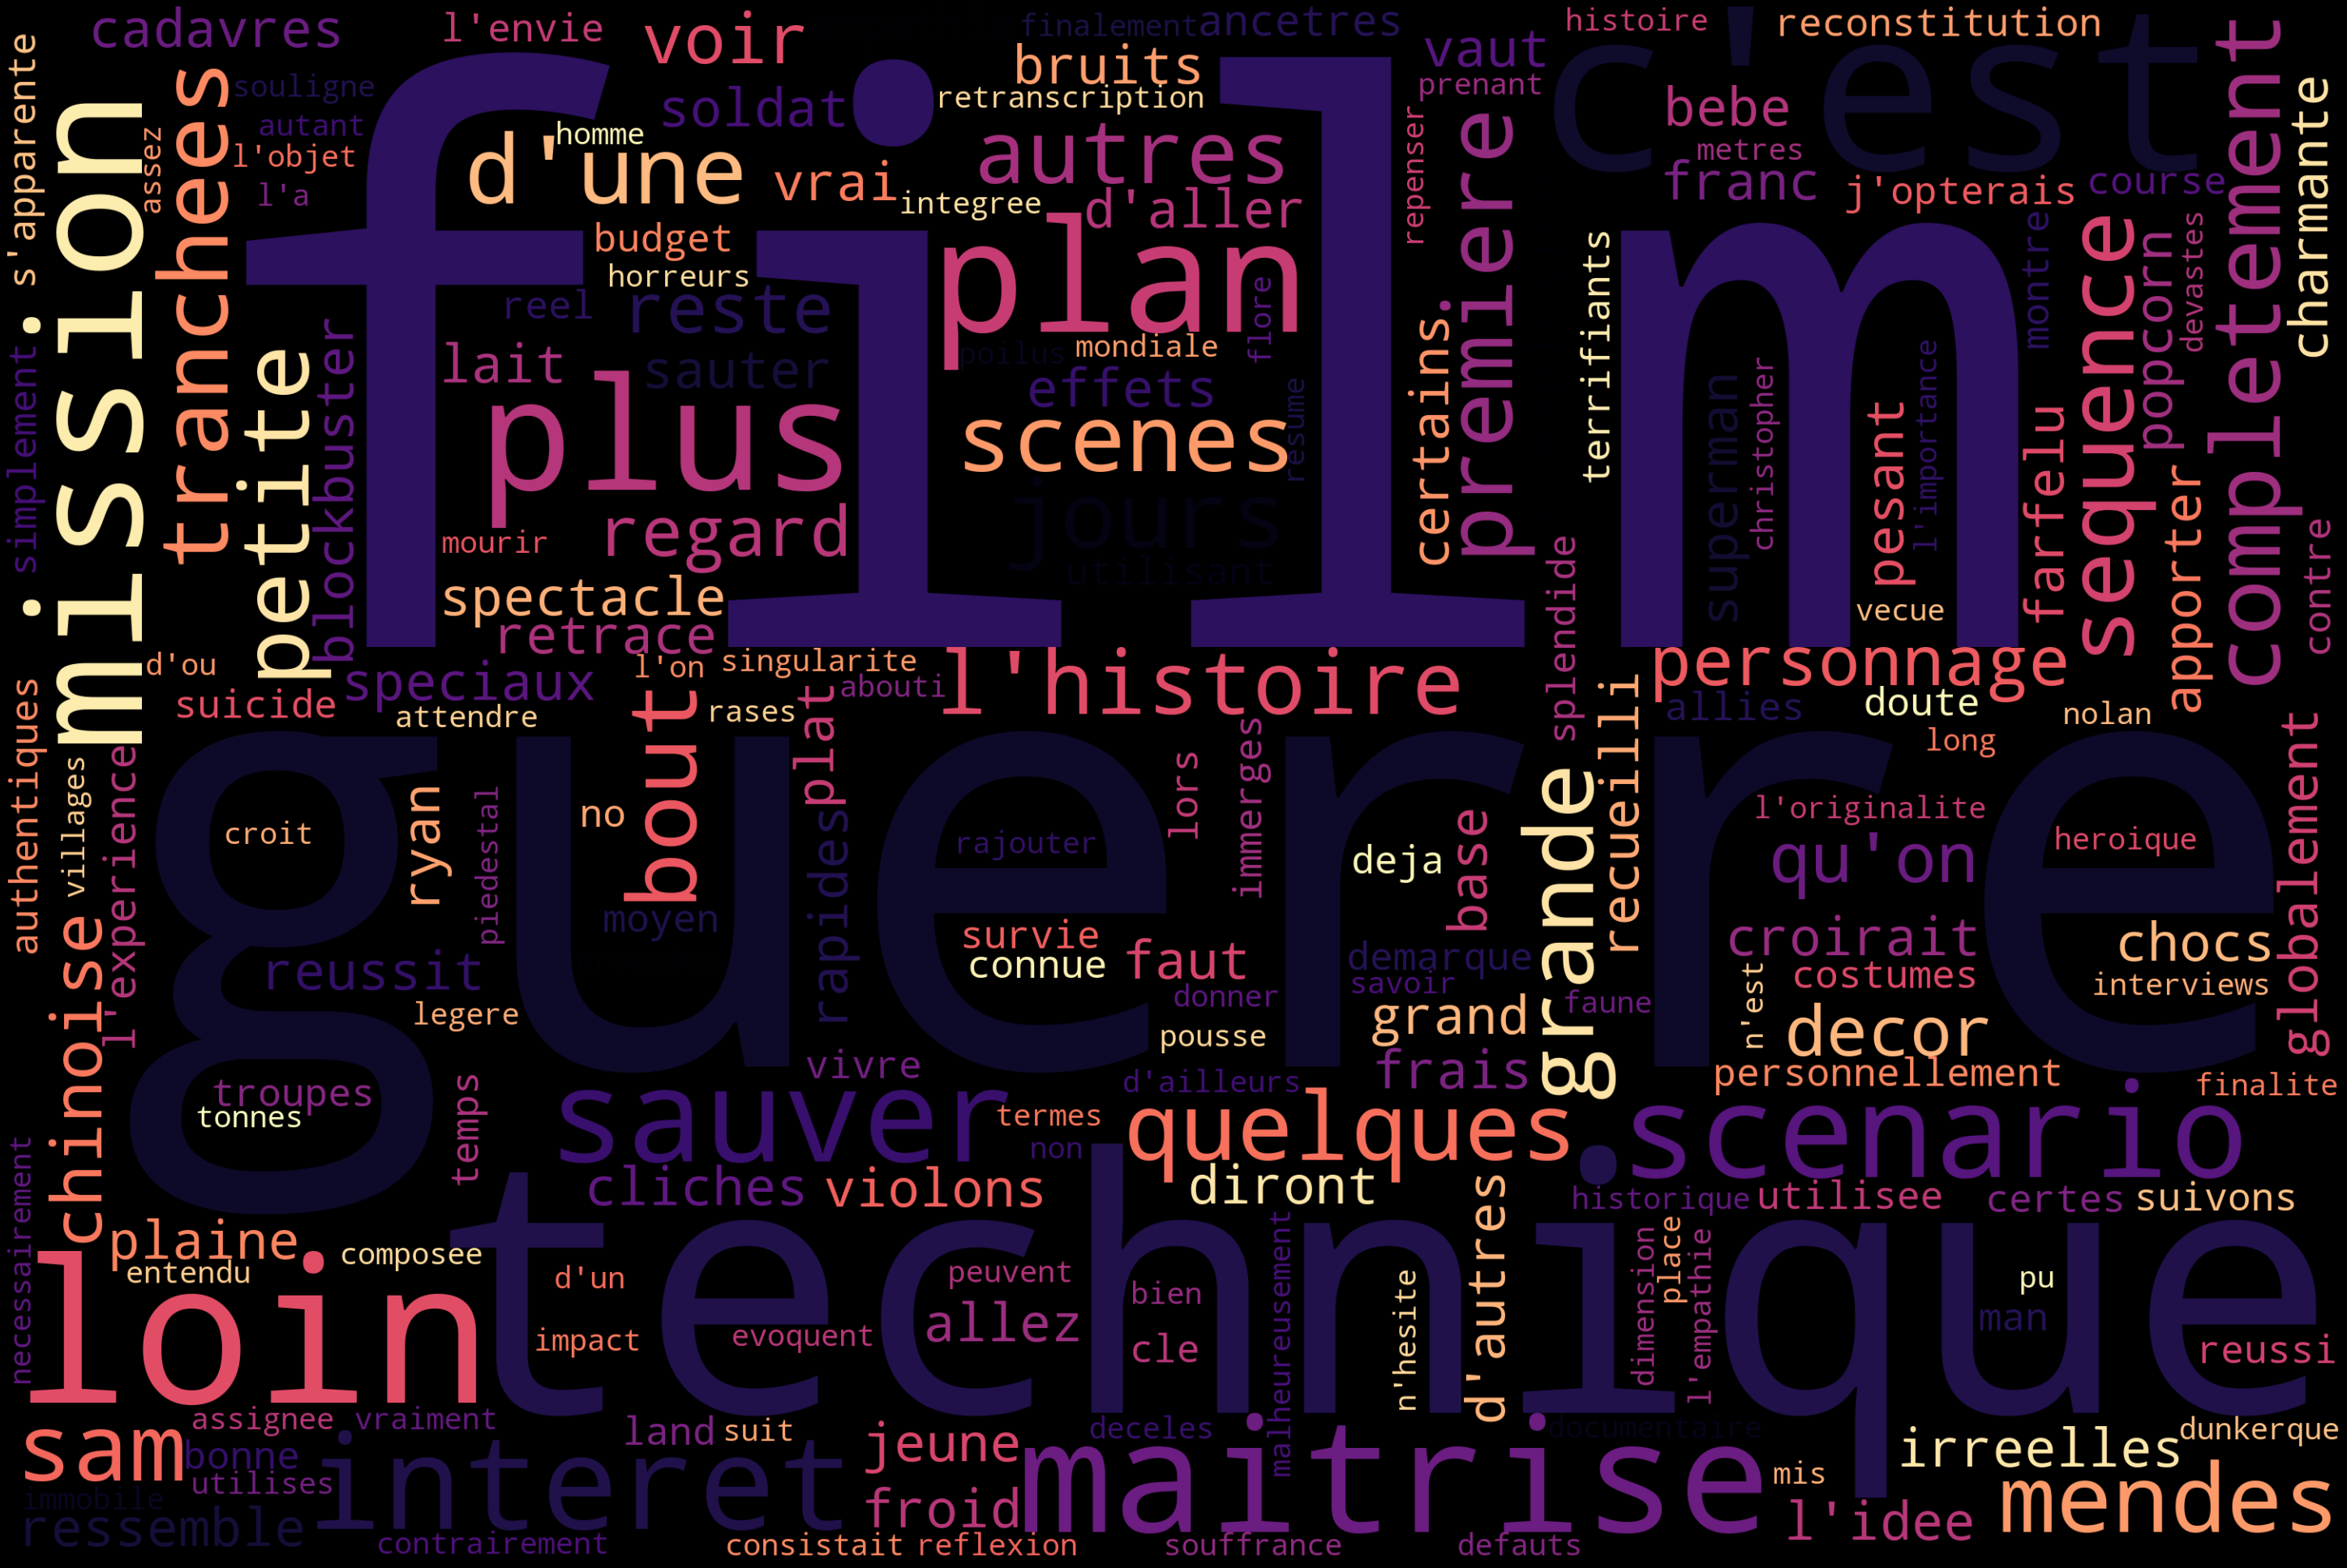

In [64]:
neg_df = comment_df.loc[comment_df['label'] == 'pos']
neg_text = [string.lower() for string in neg_df['label']]
french_stop_words = [unidecode.unidecode(word) for word in get_stop_words('fr')]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap='magma',
    stopwords = french_stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()